In [57]:
from pathlib import Path
import math
import pickle
from collections import deque
import sys

import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.transforms import v2
from tqdm.auto import tqdm

from data import setup_loader
from test_data import setup_loader as setup_test_loader
from utils import default_opts, write_results, group_features_by_label, get_features_labels, save_model, load_model, save_optimizer, load_optimizer, save_scheduler, load_scheduler, latest_checkpoint, print_result
from resnet_model import ResNet, Bottleneck, BasicBlock

In [36]:
def print_progress_bar(iteration, total, prefix="", status="", length=40):
    percent = (iteration / total)
    filled_length = int(length * percent)
    bar = "█" * filled_length + "-" * (length - filled_length)
    sys.stdout.write(f"\r{status} {prefix} |{bar}| {percent:.1%}")
    sys.stdout.flush()

def save_all(epoch, model, optimizer, scheduler, sched_kwargs, net_kwargs, stats, folder):
    ckpts = folder / "checkpoints"
    ckpts.mkdir(exist_ok=True, parents=True)
    save_model(model, net_kwargs, ckpts / f"epoch-{epoch:06d}-model.pth")
    save_optimizer(optimizer, ckpts / f"epoch-{epoch:06d}-optimizer.pth")
    save_scheduler(scheduler, sched_kwargs, ckpts / f"epoch-{epoch:06d}-scheduler.pth")
    with (folder / "stats.pkl").open("wb") as f:
        pickle.dump(stats, f, pickle.HIGHEST_PROTOCOL)

def train(name, net_kwargs, train_transforms, eval_transforms, train_dataloader, val_dataloader, batch_size, microbatch_size, epochs, lr, lr_schedule, mix):
    model_class = ResNet
    optimizer_class = torch.optim.AdamW
    scheduler_class = torch.optim.lr_scheduler.ReduceLROnPlateau

    sched_kwargs = {
        "mode": "min",
        "factor": 0.5,
        "patience": 10,
        "threshold": 1e-4,
        "threshold_mode": "rel",
        "cooldown": 0,
        "min_lr": 0.,
        "eps": 1e-8,
    }

    out_path = Path("image_models") / name

    nr_samples = len(train_dataloader.dataset)
    nr_batches = math.ceil(len(train_dataloader.dataset) / batch_size)
    nr_micro_batches = math.ceil(batch_size / microbatch_size)

    device = (
        torch.accelerator.current_accelerator() if torch.accelerator.is_available() else torch.device("cpu")
    )

    out_path.mkdir(exist_ok=True, parents=True)
    checkpoint_path, optimizer_path, scheduler_path = latest_checkpoint(out_path / "checkpoints")

    if checkpoint_path is None:
        print("Creating new model")
        model = model_class(**net_kwargs)
        model.to(device)
        optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay=0.0)
        scheduler = scheduler_class(
            optimizer,
            **sched_kwargs,
        )
        start_epoch = 1
        stats = {
            "train_loss": {},
            "train_acc": {},
            "val_loss": {},
            "val_acc": {},
        }
    else:
        print("Loading old model")
        stats_path = out_path / "stats.pkl"
        with stats_path.open("rb") as f:
            stats = pickle.load(f)
            train_loss_keys = list(stats["train_loss"].keys())
        if len(train_loss_keys):
            start_epoch = max(train_loss_keys) + 1
        else:
            start_epoch = 1
        with torch.serialization.safe_globals([Bottleneck, BasicBlock]):
            model = load_model(checkpoint_path, "train", model_class)
        model.to(device)
        optimizer = load_optimizer(optimizer_path, model, optimizer_class)
        scheduler = load_scheduler(scheduler_path, optimizer, scheduler_class)
        print(f"Loaded old model, starting epoch {start_epoch}")

    cutmix = v2.CutMix(num_classes=31)
    mixup = v2.MixUp(num_classes=31)
    cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])
    loss_fn = torch.nn.CrossEntropyLoss(reduction="sum")
    save_all(0, model, optimizer, scheduler, sched_kwargs, net_kwargs, stats, out_path)
    step = 1

    for epoch in range(start_epoch, start_epoch + epochs):
        print_progress_bar(epoch, start_epoch + epochs - 1, prefix="Epochs", length=100)

        for batch_nr, batch in enumerate(train_dataloader):
            print_progress_bar(batch_nr + 1, nr_batches, prefix="Batches", length=70)

            optimizer.zero_grad(set_to_none=True)

            if True:
                    labels = (torch.tensor(batch["label"]) - 1).to(torch.long).to(device)
                    batch = train_transforms(batch["img"]).to(device)

                    if mix:
                        batch, labels = cutmix_or_mixup(batch, labels)

                    preds = model(batch)
                    loss = loss_fn(preds, labels)
                    loss.backward()
            else:
                for ubatch_nr, i in enumerate(range(0, this_batch_size, microbatch_size)):
                    print_progress_bar(ubatch_nr + 1, nr_micro_batches, prefix="uBatches", length=40)

                    microbatch = train_transforms(batch["img"][i : i + microbatch_size]).to(device)
                    labels = (torch.tensor(batch["label"][i : i + microbatch_size]) - 1).to(torch.long).to(device)

                    preds = model(microbatch)
                    loss = loss_fn(preds, labels)
                    loss.backward()

            optimizer.step()
            step += 1

        def get_stats(dataloader):
            model.eval()
            with torch.inference_mode():
                preds = []
                labels = []
                for batch in dataloader:
                    preds.append(model(eval_transforms(batch["img"])))
                    labels.extend(batch["label"])
                preds = torch.cat(preds, axis=0)
                labels = torch.tensor(labels) - 1
                loss = loss_fn(preds, labels) / preds.size(0)
                model_labels = torch.argmax(preds, dim=1)
                acc = torch.sum(model_labels == labels) / labels.size(0)
            model.train()
            return loss, acc

        train_loss, train_acc = get_stats(train_dataloader)
        val_loss, val_acc = get_stats(val_dataloader)

        if lr_schedule:
            scheduler.step(train_loss)

        epoch_stats = {}
        epoch_stats["train_loss"] = train_loss.item()
        epoch_stats["train_acc"] = train_acc.item()
        epoch_stats["val_loss"] = val_loss.item()
        epoch_stats["val_acc"] = val_acc.item()
        ss = []
        for k, v in epoch_stats.items():
            stats[k][epoch] = v
            ss.append(f"{k}={v:.5f}")
        print(f"\n{epoch=} lr={scheduler.get_last_lr()} {" ".join(ss)}")
        save_all(epoch, model, optimizer, scheduler, sched_kwargs, net_kwargs, stats, out_path)

    print(f"Finished epoch {epoch}")
    return model, stats

In [50]:
# !rm -rf image_models/tmp
epochs = 500
lr = 1e-2
lr_schedule = True
mix = False

train_transforms = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.ColorJitter(0.2, 0.2, 0.2, 0.2),
    v2.ToDtype(torch.float32, scale=True),
    v2.GaussianNoise(mean=0.0, sigma=0.1, clip=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

eval_transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch_size = len(setup_loader(data_dir="data/train", batch_size=1, shuffle=True).dataset)
dl_train = setup_loader(data_dir="data/train", batch_size=batch_size, shuffle=True)
ds_train = dl_train.dataset
dl_val = setup_loader(data_dir="data/dev", batch_size=batch_size, shuffle=False)
ds_val = dl_val.dataset

net_kwargs = {
    "block": Bottleneck,
    "layers": [3, 4, 6, 3],
    "num_classes": 31,
    "zero_init_residual": False,
    "layer_planes": (np.array([8, 16, 32, 64]) * 2).tolist(),
    "replace_stride_with_dilation": [False] * 3,
    "dropout_p": 0.0,
}

model, history = train("tmp", net_kwargs, train_transforms, eval_transforms, dl_train, dl_val, batch_size, batch_size, epochs, lr, lr_schedule, mix)

Creating new model
 Batches |██████████████████████████████████████████████████████████████████████| 100.0%---------------------| 0.2%
epoch=1 lr=[0.01] train_loss=240.61720 train_acc=0.03226 val_loss=285.66010 val_acc=0.03226
 Batches |██████████████████████████████████████████████████████████████████████| 100.0%---------------------| 0.4%
epoch=2 lr=[0.01] train_loss=15805.96875 train_acc=0.03226 val_loss=19817.26367 val_acc=0.03226
 Batches |██████████████████████████████████████████████████████████████████████| 100.0%---------------------| 0.6%
epoch=3 lr=[0.01] train_loss=288067.78125 train_acc=0.03226 val_loss=375156.12500 val_acc=0.03226
 Batches |██████████████████████████████████████████████████████████████████████| 100.0%---------------------| 0.8%
epoch=4 lr=[0.01] train_loss=888267.81250 train_acc=0.03226 val_loss=1114429.50000 val_acc=0.03226
 Batches |██████████████████████████████████████████████████████████████████████| 100.0%---------------------| 1.0%
epoch=5 lr=[0.01

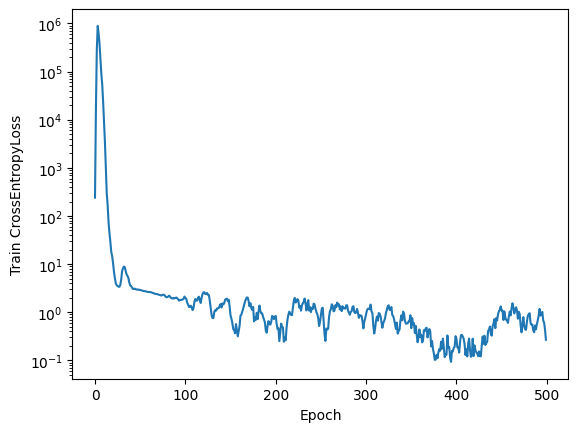

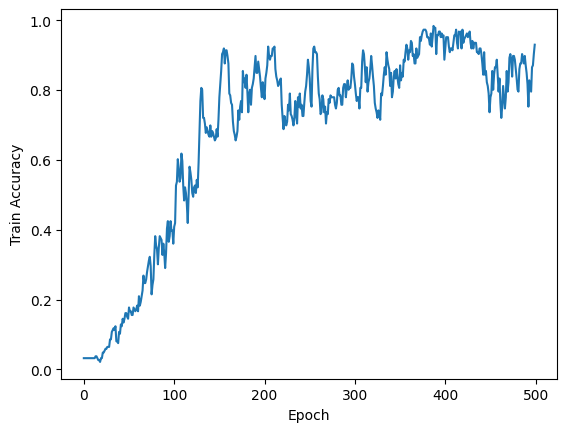

In [80]:
plt.plot(history["train_loss"].values())
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Train CrossEntropyLoss")
plt.show()
plt.close()

plt.plot(history["train_acc"].values())
plt.xlabel("Epoch")
plt.ylabel("Train Accuracy")
plt.show()
plt.close()

In [63]:
opts = default_opts

dl_test = setup_test_loader(data_dir="data/eval", batch_size=16, shuffle=False)

model.eval()
with torch.inference_mode():
    preds = []
    segments = []
    for batch in dl_test:
        preds.append(model(eval_transforms(batch["img"])))
        segments.extend(batch["segment"])
    preds = torch.cat(preds, axis=0)
    probs = torch.nn.functional.softmax(preds, dim=1)
model.train()

write_results(Path("results_cnn.txt"), probs.numpy(), segments, opts, is_score=False)
#write_results(Path("results_cnn.txt"), preds.numpy(), segments, opts, is_score=True)